K means


In [0]:
!pip install dgl


In [0]:
# load tqdm
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook as tqdm

In [0]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import math
import dgl
from collections import Counter

#Test with small size: Karata Dataset

In [0]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [0]:
G = build_karate_club_graph()

In [6]:
G.number_of_nodes()

34

In [0]:
import numpy
matrix_all = numpy.empty((G.number_of_nodes(), G.number_of_nodes()))  

In [8]:
matrix = G.adjacency_matrix()

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [0]:
matrix = matrix.to_dense()

In [16]:
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = 0
        for n in range(n_nodes):          
            x += int((matrix[i][n]-matrix[j][n]))**2
            
        matrix_all[i][j] = math.sqrt(x)    
        #print (math.sqrt(x))

# Cora

In [0]:
from dgl import DGLGraph
from dgl.data import CoraFull

In [18]:
data = citegrh.load_cora()
G = DGLGraph( data.graph)

Extracting file to /root/.dgl/cora


In [19]:
G

DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={}
         edata_schemes={})

In [0]:
import numpy
matrix_all = numpy.empty((G.number_of_nodes(), G.number_of_nodes()))  

In [21]:
matrix = G.adjacency_matrix()

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [95]:
#Distance measure Burt, 1976 in 04_2010
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = math.sqrt(sum(abs((matrix[i]-matrix[j]).coalesce().values().numpy())))
        matrix_all[i][j] = x    
        #print (math.sqrt(x))

In [0]:
import pickle
#output = open('data/k-means_distance_matrix.pkl', 'wb')
#pickle.dump(matrix_all,output)

In [0]:
from google.colab import files
files.download('data/k-means_distance_matrix.pkl')

In [0]:
from sklearn.cluster import KMeans
import numpy as np
X = matrix_all
kmeans = KMeans(n_clusters=7).fit(X)
#kmeans.labels_
#kmeans.cluster_centers_

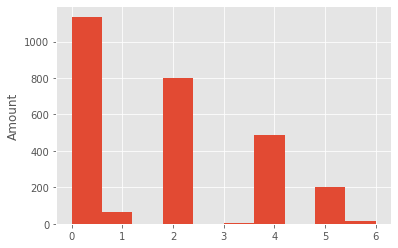

In [113]:
#Distribution of lables
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
x = kmeans.labels_
plt.hist(x)
plt.ylabel('Amount');

In [114]:
print(Counter(x).keys()) 
print(Counter(x).values())

dict_keys([2, 4, 0, 1, 5, 6, 3])
dict_values([801, 485, 1136, 62, 204, 16, 4])


Text(0, 0.5, 'Amount')

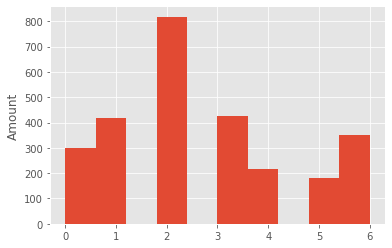

In [115]:
#How the real labels are distributed
x = data.labels
plt.style.use('ggplot')
plt.hist(x)
plt.ylabel('Amount')

In [116]:
print(Counter(x).keys()) 
print(Counter(x).values())

dict_keys([2, 5, 4, 3, 6, 1, 0])
dict_values([818, 180, 217, 426, 351, 418, 298])


In [0]:
# Imports
import numpy as np
from scipy import sparse as sp
from math import log
import pandas as pd
from sklearn import metrics as skmetrics

import torch as th
import torch.nn.functional as F

import itertools

In [0]:
def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")


def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)
        # print(contingency.todense())
        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))
        # print(nz_val)
        log_contingency_nm = np.log(nz_val)
        # print(log_contingency_nm)
        contingency_nm = nz_val / contingency_sum
        # print(contingency_nm)

        # Don't need to calculate the full outer product, just for non-zeroes
        outer = (pi.take(nzx).astype(np.int64, copy=False)
                 * pj.take(nzy).astype(np.int64, copy=False))
        # print(outer)
        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
        # print(log_outer)
        mi = (contingency_nm * (log_contingency_nm -
                                log(contingency_sum)) + contingency_nm * log_outer)
        # print(mi)
        return mi.sum()
    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


In [119]:
rand_score(data.labels,kmeans.labels_)

0.004368230906763326

In [120]:
mutual_info_score(data.labels,kmeans.labels_)

0.0034842619703662494

In [121]:
variation_of_information_score(data.labels,kmeans.labels_)

3.160182941224538

In [0]:
 a = itertools.permutations(range(7))

In [0]:
for x in a:
    print(x)